In [21]:
import numpy as np 
import pandas as pd 

import os

In [23]:

import os
for dirname, _, filenames in os.walk('/data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [25]:
base_path = "data\\diagnosis-of-diabetic-retinopathy\\train"
categories = ["DR", "No_DR"]

In [27]:
image_paths = []
labels = []

for category in categories:
    category_path = os.path.join(base_path, category)
    for image_name in os.listdir(category_path):
        image_path = os.path.join(category_path, image_name)
        image_paths.append(image_path)
        labels.append(category)  

df = pd.DataFrame({
    "image_path": image_paths,
    "label": labels
})

In [29]:
df.head()

,image_path,label
0,data\diagnosis-of-diabetic-retinopathy\train\D...,DR
1,data\diagnosis-of-diabetic-retinopathy\train\D...,DR
2,data\diagnosis-of-diabetic-retinopathy\train\D...,DR
3,data\diagnosis-of-diabetic-retinopathy\train\D...,DR
4,data\diagnosis-of-diabetic-retinopathy\train\D...,DR


In [31]:
df.tail()

,image_path,label
2071,data\diagnosis-of-diabetic-retinopathy\train\N...,No_DR
2072,data\diagnosis-of-diabetic-retinopathy\train\N...,No_DR
2073,data\diagnosis-of-diabetic-retinopathy\train\N...,No_DR
2074,data\diagnosis-of-diabetic-retinopathy\train\N...,No_DR
2075,data\diagnosis-of-diabetic-retinopathy\train\N...,No_DR


In [33]:
df.shape

(2076, 2)

In [35]:
df.columns

Index(['image_path', 'label'], dtype='object')

In [37]:
df.duplicated().sum()

0

In [39]:
df.isnull().sum()

image_path    0
label         0
dtype: int64

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2076 entries, 0 to 2075
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  2076 non-null   object
 1   label       2076 non-null   object
dtypes: object(2)
memory usage: 32.6+ KB


In [43]:
df.nunique()

image_path    2076
label            2
dtype: int64

In [45]:
df['label'].unique()

array(['DR', 'No_DR'], dtype=object)

In [47]:
df['label'].value_counts()

label
DR       1050
No_DR    1026
Name: count, dtype: int64

C:\Users\ashis\AppData\Local\Temp\ipykernel_3360\1753293280.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="label", palette="viridis")


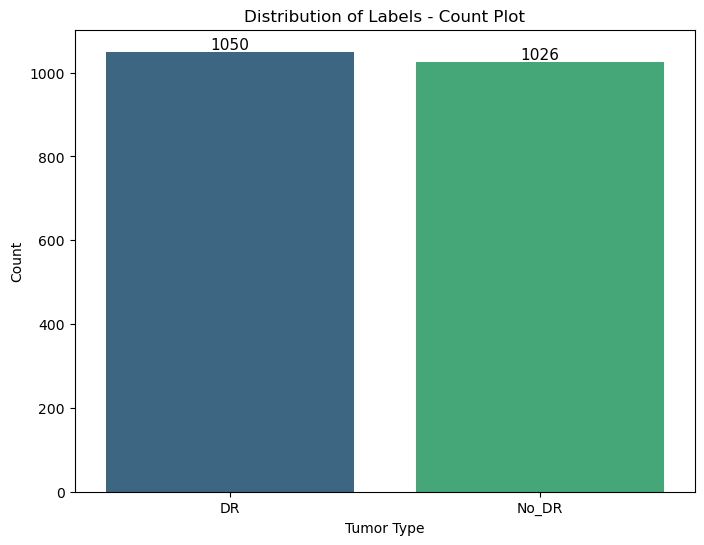

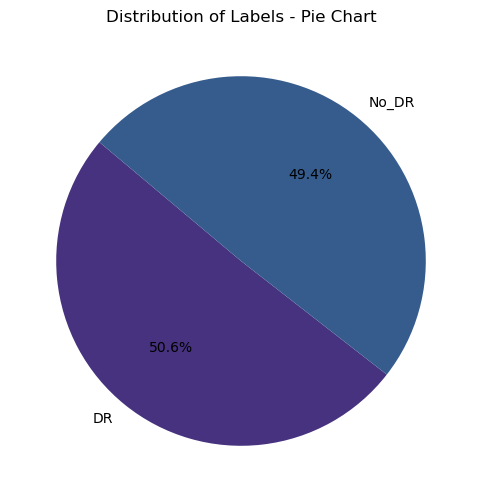

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.countplot(data=df, x="label", palette="viridis")
plt.title("Distribution of Labels - Count Plot")
plt.xlabel("Tumor Type")
plt.ylabel("Count")

for p in plt.gca().patches:
    plt.gca().annotate(f'{int(p.get_height())}', 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha='center', va='center', fontsize=11, color='black', xytext=(0, 5), 
                       textcoords='offset points')

plt.show()

label_counts = df['label'].value_counts()
plt.figure(figsize=(8, 6))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("viridis"))
plt.title("Distribution of Labels - Pie Chart")
plt.show()

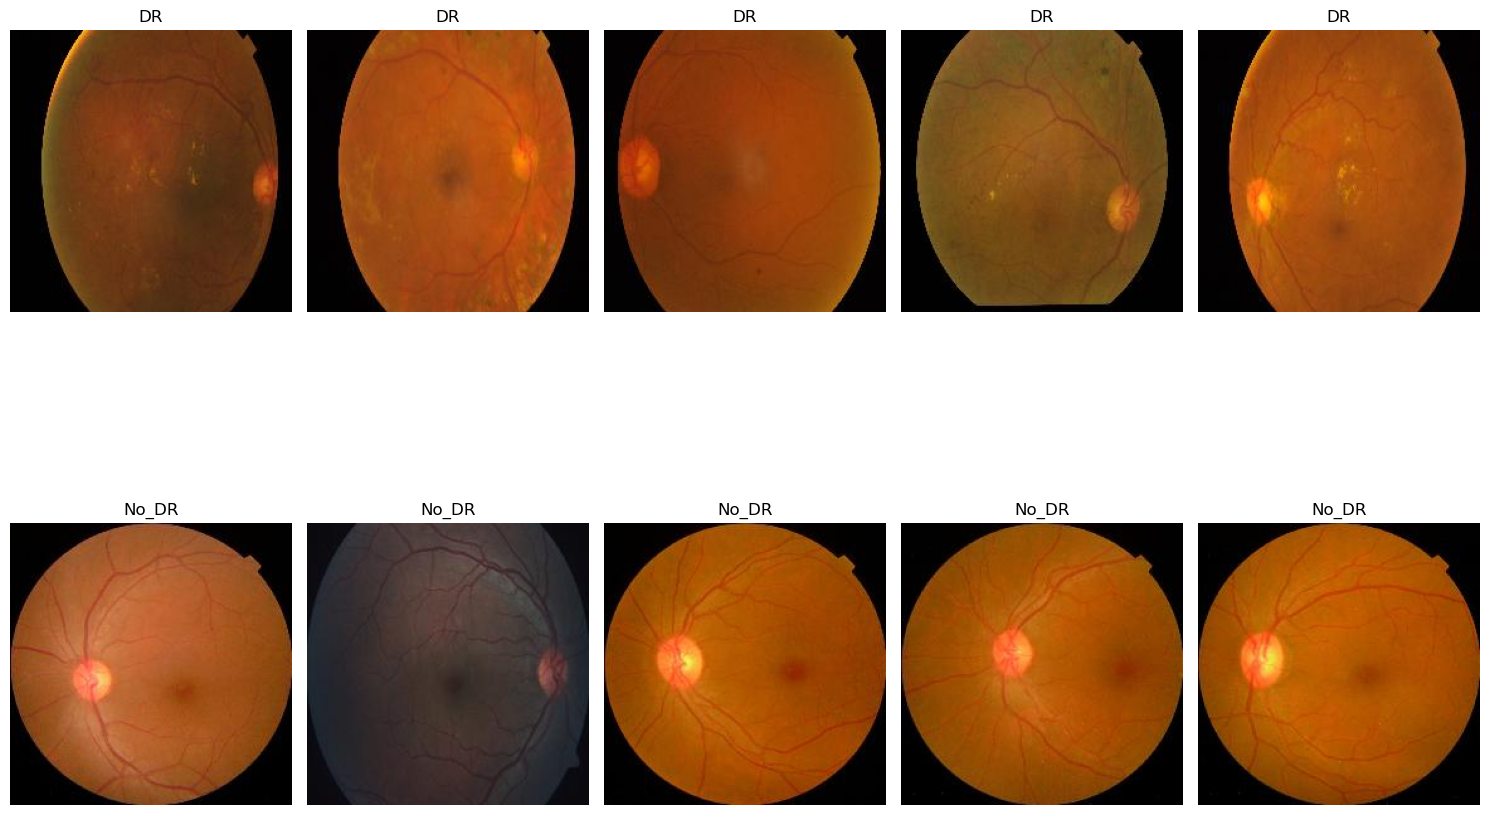

In [50]:
import cv2

num_images = 5

plt.figure(figsize=(15, 12))

for i, category in enumerate(categories):
    category_images = df[df['label'] == category]['image_path'].iloc[:num_images]

    for j, img_path in enumerate(category_images):

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  

        plt.subplot(len(categories), num_images, i * num_images + j + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(category)

plt.tight_layout()
plt.show()

In [52]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

df['category_encoded'] = label_encoder.fit_transform(df['label'])

In [55]:
df = df[['image_path', 'category_encoded']]

In [57]:
from imblearn.over_sampling import RandomOverSampler

In [59]:
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(df[['image_path']], df['category_encoded'])

In [61]:
df_resampled = pd.DataFrame(X_resampled, columns=['image_path'])
df_resampled['category_encoded'] = y_resampled

In [63]:
print("\nClass distribution after oversampling:")
print(df_resampled['category_encoded'].value_counts())


Class distribution after oversampling:
category_encoded
0    1050
1    1050
Name: count, dtype: int64


In [65]:
df_resampled

,image_path,category_encoded
0,data\diagnosis-of-diabetic-retinopathy\train\D...,0
1,data\diagnosis-of-diabetic-retinopathy\train\D...,0
2,data\diagnosis-of-diabetic-retinopathy\train\D...,0
3,data\diagnosis-of-diabetic-retinopathy\train\D...,0
4,data\diagnosis-of-diabetic-retinopathy\train\D...,0
...,...,...
2095,data\diagnosis-of-diabetic-retinopathy\train\N...,1
2096,data\diagnosis-of-diabetic-retinopathy\train\N...,1
2097,data\diagnosis-of-diabetic-retinopathy\train\N...,1
2098,data\diagnosis-of-diabetic-retinopathy\train\N...,1


In [67]:
import time
import shutil
import pathlib
import itertools
from PIL import Image

import cv2
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

import warnings
warnings.filterwarnings("ignore")

print ('check')

check


In [68]:
df_resampled['category_encoded'] = df_resampled['category_encoded'].astype(str)

In [69]:
train_df_new, temp_df_new = train_test_split(
    df_resampled,
    train_size=0.8,  
    shuffle=True,
    random_state=42,
    stratify=df_resampled['category_encoded']  
)

valid_df_new, test_df_new = train_test_split(
    temp_df_new,
    test_size=0.5,  
    shuffle=True,
    random_state=42,
    stratify=temp_df_new['category_encoded'] 
)

In [70]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 16
img_size = (224, 224)
channels = 3  
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator(rescale=1./255)  
ts_gen = ImageDataGenerator(rescale=1./255)

train_gen_new = tr_gen.flow_from_dataframe(
    train_df_new,
    x_col='image_path',  
    y_col='category_encoded',     
    target_size=img_size,
    class_mode='binary',  
    color_mode='rgb', 
    shuffle=True,
    batch_size=batch_size
)

valid_gen_new = ts_gen.flow_from_dataframe(
    valid_df_new,
    x_col='image_path',  
    y_col='category_encoded',     
    target_size=img_size,
    class_mode='binary',  
    color_mode='rgb', 
    shuffle=True,
    batch_size=batch_size
)

test_gen_new = ts_gen.flow_from_dataframe(
    test_df_new,
    x_col='image_path', 
    y_col='category_encoded',    
    target_size=img_size,
    class_mode='binary',  
    color_mode='rgb', 
    shuffle=False,  
    batch_size=batch_size
)

Found 1680 validated image filenames belonging to 2 classes.
Found 210 validated image filenames belonging to 2 classes.
Found 210 validated image filenames belonging to 2 classes.


In [71]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [77]:
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    print("Using GPU")
else:
    print("Using CPU")

Using CPU


In [79]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [81]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (GlobalAveragePooling2D, Dense, Dropout, GaussianNoise, 
                                     Input, MultiHeadAttention, Reshape)
from tensorflow.keras.optimizers import Adam

def create_vgg16_model(input_shape):
    inputs = Input(shape=input_shape)
    
    base_model = VGG16(weights='imagenet', input_tensor=inputs, include_top=False)
    
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output

    height, width, channels = 7, 7, 512  
    x = Reshape((height * width, channels))(x)
    
    attention_output = MultiHeadAttention(num_heads=8, key_dim=channels)(x, x)
    attention_output = Reshape((height, width, channels))(attention_output)
    
    x = GaussianNoise(0.25)(attention_output)
    
    x = GlobalAveragePooling2D()(x)
    
    x = Dense(512, activation='relu')(x)
    x = GaussianNoise(0.25)(x)  
    x = Dropout(0.25)(x)  
    
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=inputs, outputs=outputs)

    return model

input_shape = (224, 224, 3)

cnn_model = create_vgg16_model(input_shape)

cnn_model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

In [83]:
import time

In [85]:
start_time = time.time()
history = cnn_model.fit(
    train_gen_new,
    validation_data=valid_gen_new,
    epochs=5,  
    callbacks=[early_stopping],
    verbose=1
)
end_time = time.time()

Epoch 1/5
105/105 ━━━━━━━━━━━━━━━━━━━━ 121s 1s/step - accuracy: 0.7108 - loss: 0.5239 - val_accuracy: 0.9095 - val_loss: 0.2234
Epoch 2/5
105/105 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - accuracy: 0.9161 - loss: 0.2310 - val_accuracy: 0.9190 - val_loss: 0.1816
Epoch 3/5
105/105 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - accuracy: 0.9250 - loss: 0.2129 - val_accuracy: 0.9381 - val_loss: 0.1819
Epoch 4/5
105/105 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.9212 - loss: 0.2167 - val_accuracy: 0.9286 - val_loss: 0.1449
Epoch 5/5
105/105 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.9365 - loss: 0.1813 - val_accuracy: 0.9476 - val_loss: 0.1451


In [86]:
inference_time = end_time - start_time
print(f"Inference time: {inference_time:.4f} seconds")

Inference time: 552.0911 seconds


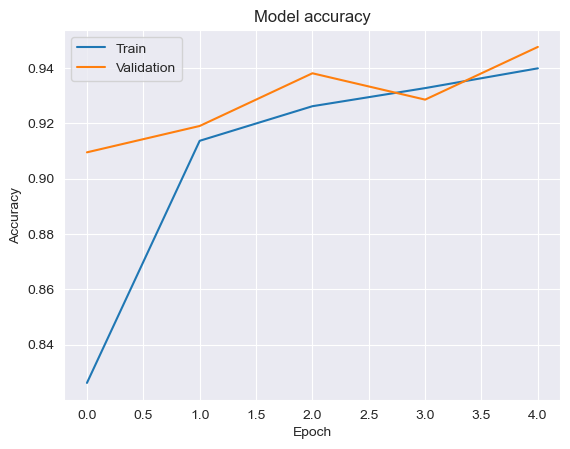

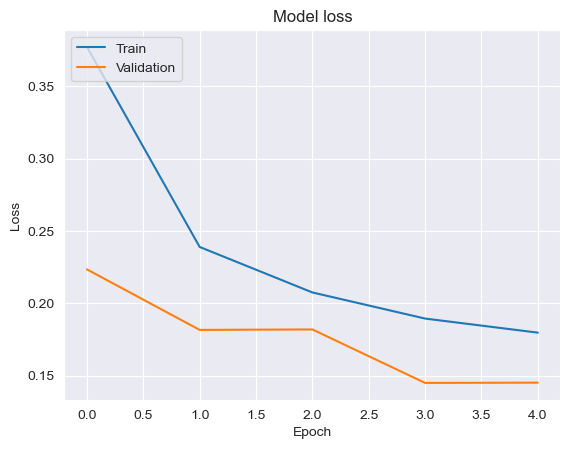

In [87]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [88]:
test_labels = test_gen_new.classes  
predictions = cnn_model.predict(test_gen_new)  
predicted_labels = (predictions > 0.5).astype(int).flatten()

14/14 ━━━━━━━━━━━━━━━━━━━━ 12s 824ms/step


In [89]:
from sklearn.metrics import classification_report

report = classification_report(test_labels, predicted_labels, target_names=list(test_gen_new.class_indices.keys()))
print(report)

              precision    recall  f1-score   support

           0       0.99      0.90      0.95       105
           1       0.91      0.99      0.95       105

    accuracy                           0.95       210
   macro avg       0.95      0.95      0.95       210
weighted avg       0.95      0.95      0.95       210



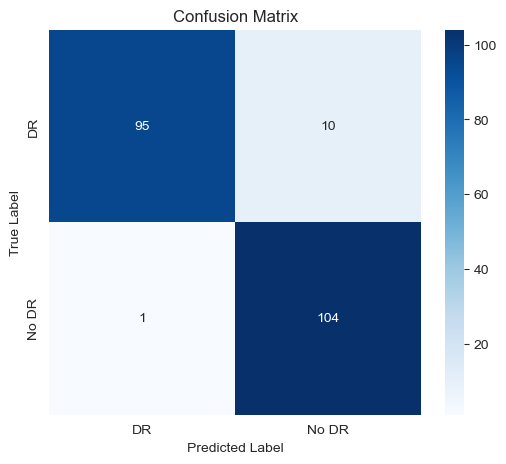

In [90]:
conf_matrix = confusion_matrix(test_labels, predicted_labels)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['DR', 'No DR'], yticklabels=['DR', 'No DR'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [91]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (GlobalAveragePooling2D, Dense, Dropout, GaussianNoise, 
                                     Input, MultiHeadAttention, Reshape)
from tensorflow.keras.optimizers import Adam

def create_lightweight_model(input_shape):
    inputs = Input(shape=input_shape)
    base_model = MobileNetV2(weights='imagenet', input_tensor=inputs, include_top=False)
    for layer in base_model.layers:
        layer.trainable = False
    x = base_model.output
    height, width, channels = x.shape[1], x.shape[2], x.shape[3]
    x = Reshape((height * width, channels))(x)
    attention_output = MultiHeadAttention(num_heads=4, key_dim=channels)(x, x)
    attention_output = Reshape((height, width, channels))(attention_output)
    x = GaussianNoise(0.2)(attention_output)
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = GaussianNoise(0.2)(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

input_shape = (224, 224, 3)
cnn_model = create_lightweight_model(input_shape)
cnn_model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [92]:
import time

In [93]:
start_time = time.time()
history = cnn_model.fit(
    train_gen_new,
    validation_data=valid_gen_new,
    epochs=5,  
    callbacks=[early_stopping],
    verbose=1
)
end_time = time.time()

Epoch 1/5
105/105 ━━━━━━━━━━━━━━━━━━━━ 48s 407ms/step - accuracy: 0.8468 - loss: 0.3530 - val_accuracy: 0.9714 - val_loss: 0.0754
Epoch 2/5
105/105 ━━━━━━━━━━━━━━━━━━━━ 41s 393ms/step - accuracy: 0.9575 - loss: 0.1458 - val_accuracy: 0.9714 - val_loss: 0.0860
Epoch 3/5
105/105 ━━━━━━━━━━━━━━━━━━━━ 41s 392ms/step - accuracy: 0.9604 - loss: 0.1263 - val_accuracy: 0.9762 - val_loss: 0.0918
Epoch 4/5
105/105 ━━━━━━━━━━━━━━━━━━━━ 41s 393ms/step - accuracy: 0.9723 - loss: 0.0798 - val_accuracy: 0.9762 - val_loss: 0.1046
Epoch 5/5
105/105 ━━━━━━━━━━━━━━━━━━━━ 42s 401ms/step - accuracy: 0.9745 - loss: 0.0724 - val_accuracy: 0.9762 - val_loss: 0.0777


In [94]:
inference_time = end_time - start_time
print(f"Inference time: {inference_time:.4f} seconds")

Inference time: 214.1538 seconds


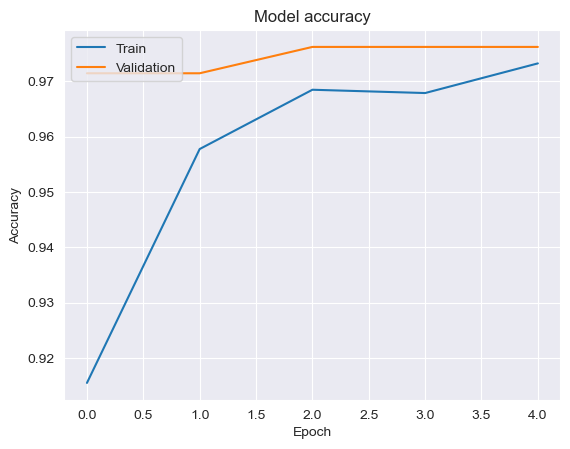

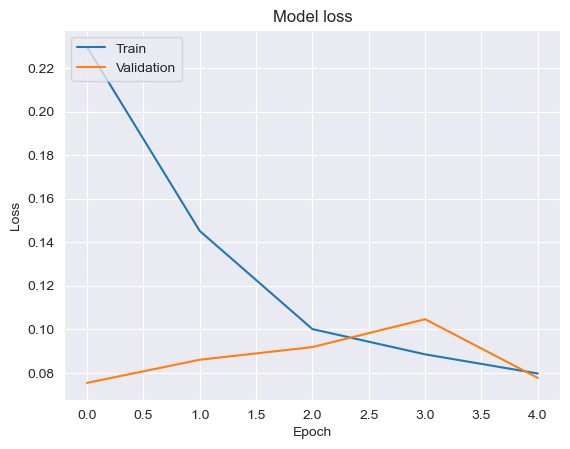

In [95]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [96]:
test_labels = test_gen_new.classes  
predictions = cnn_model.predict(test_gen_new)  
predicted_labels = (predictions > 0.5).astype(int).flatten()

14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 217ms/step


In [97]:
from sklearn.metrics import classification_report

report = classification_report(test_labels, predicted_labels, target_names=list(test_gen_new.class_indices.keys()))
print(report)

              precision    recall  f1-score   support

           0       1.00      0.94      0.97       105
           1       0.95      1.00      0.97       105

    accuracy                           0.97       210
   macro avg       0.97      0.97      0.97       210
weighted avg       0.97      0.97      0.97       210



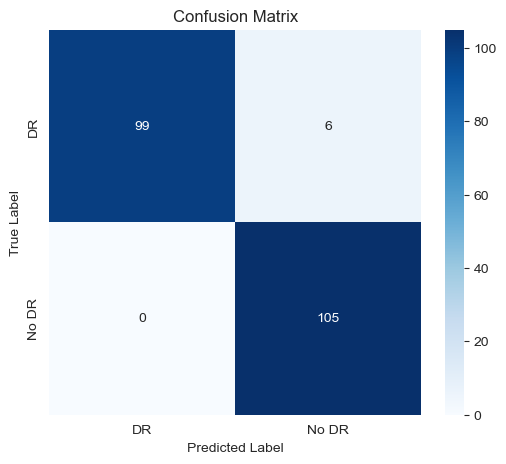

In [98]:
conf_matrix = confusion_matrix(test_labels, predicted_labels)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['DR', 'No DR'], yticklabels=['DR', 'No DR'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()